## Supervised

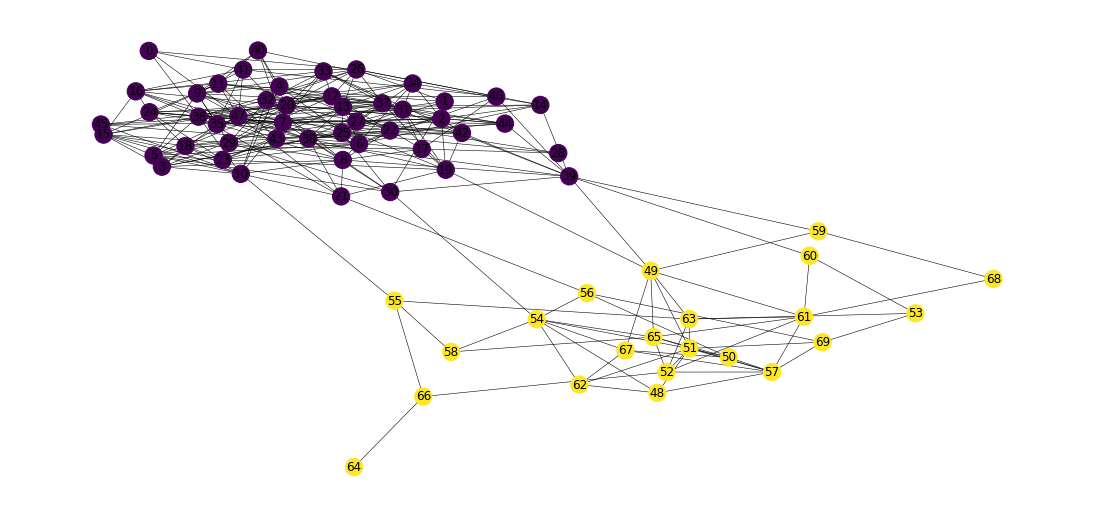

torch.Size([70, 70])


In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import warnings 
warnings.filterwarnings("ignore")
# Let's create a stochastic block model
sizes = [48, 22]

probs = [[0.2, 0.007],
         [0.007, 0.2]]
         

G = nx.stochastic_block_model(sizes, probs, seed=0)
#Let's color the nodes with the same color of the block
for i in range(len(sizes)):
    for j in range(sizes[i]):
        G.nodes[j+i*48]['color'] = i
pos = nx.spring_layout(G,seed=42)
plt.figure(figsize=(15,7))
#draw nodes with mapped color
nx.draw(G,
        pos=pos,
        node_color=[G.nodes[node]['color'] for node in G.nodes()],
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=1,
        cmap=plt.cm.viridis,
        #node_size=100,
        with_labels=True,
        alpha=1,
        )

plt.show()
# Get the adjacency matrix
adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.todense()).float()
print(adj.shape)

In [18]:
#Let's save the degree of each node in a torch tensor
from torch_geometric.utils import to_dense_adj
print(len(G.nodes()))
degrees = torch.tensor([G.degree(node) for node in G.nodes()],dtype=torch.float32).reshape(-1,1)
#Parse the graph to a torch_geometric.data.Data object
from torch_geometric.utils import from_networkx
print(G)
A = G
C = nx.Graph()
C.add_nodes_from(A.nodes())
C.add_edges_from(A.edges())
data = from_networkx(C)
print(data)
data.x = to_dense_adj(data.edge_index)[0] #Adj 
data.y = torch.tensor([0,0,0,1,1,2,2,2,2]).reshape(-1,1)
data.edge_index = adj.nonzero().t()
L_normalized = torch.Tensor(nx.normalized_laplacian_matrix(C).todense())
print(L_normalized.shape)
print(data)

70
Graph named 'stochastic_block_model' with 70 nodes and 285 edges
Data(edge_index=[2, 570], num_nodes=70)
torch.Size([70, 70])
Data(edge_index=[2, 570], num_nodes=70, x=[70, 70], y=[9, 1])


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  42
Number of nodes of class 1:  19
Number of nodes of class 2:  9
Data(edge_index=[2, 570], num_nodes=70, x=[70, 3703], y=[70])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


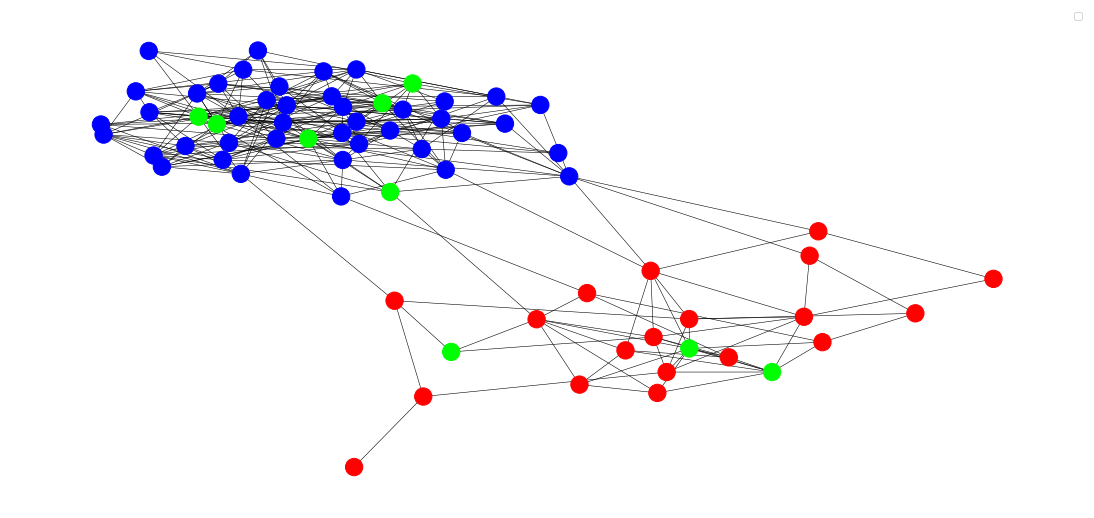

In [19]:
# Let's add the features and the labels of the citeseer dataset
import torch
import networkx as nx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import homophily
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Let's add the features and the labels of the citeseer dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import homophily
dataset = Planetoid(root='./data', name='citeseer')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
features_of_class_0 = data_citeseer.x[labels_of_class_0]
labels_of_class_1 = data_citeseer.y == 1
features_of_class_1 = data_citeseer.x[labels_of_class_1]
labels_of_class_2 = data_citeseer.y == 2
features_of_class_2 = data_citeseer.x[labels_of_class_2]
from utils import rand_train_test_idx

# Let's assing to data the features and the labels of the 35 nodes of each class
data.x = torch.cat((
                features_of_class_0[:30],
                features_of_class_2[0:1],
                features_of_class_2[30:33],
                features_of_class_2[1:2],
                features_of_class_2[2:6], 
                features_of_class_0[45:54],
                
                features_of_class_1[:3],
                features_of_class_2[7:8],
                features_of_class_1[6:11],
                features_of_class_2[9:11],
                features_of_class_1[12:23],
),dim=0)
                
data.y = torch.cat((
                        data_citeseer.y[labels_of_class_0][:30],  # 30
                        data_citeseer.y[labels_of_class_2][0:1],  # 1
                        data_citeseer.y[labels_of_class_0][30:33],# 
                        data_citeseer.y[labels_of_class_2][1:2],  # 1
                        data_citeseer.y[labels_of_class_2][2:6],  # 4
                        data_citeseer.y[labels_of_class_0][45:54],# 9
                                                                  # 
                        data_citeseer.y[labels_of_class_1][:3],
                        data_citeseer.y[labels_of_class_2][7:8],
                        data_citeseer.y[labels_of_class_1][6:11],
                        data_citeseer.y[labels_of_class_2][9:10],
                        data_citeseer.y[labels_of_class_2][7:8],
                        data_citeseer.y[labels_of_class_1][12:23],
),dim=0)

# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
print("Number of nodes of class 2: ",len(data.y[data.y==2]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=1,
        cmap=plt.cm.brg,
        #node_size=100,
        with_labels=False,
        alpha=1,
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
plt.legend()
plt.show()

## Models

In [20]:
from torch_geometric.nn import GCNConv,DenseGCNConv
from torch.nn import Linear
import torch.nn.functional as F
from odwire_layer import *
class ODwire(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,num_centers,adj_dim, n_layers,out_channels,drop_out = 0.5):
        super(ODwire, self).__init__()
        torch.manual_seed(1234)
        # CT-Layer
        #self.eiguen = torch.nn.Parameter(torch.ones(adj_dim, num_centers))
        self.MLP = Linear(adj_dim, num_centers)#Texas 4 # X -> S
        #GNN
        # We are going to create a list of layers of the GNN
        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            self.convs.append(DenseGCNConv(in_channels, hidden_channels))
        #Aux
        self.drop_out = drop_out
        self.new_adj = None
        self.embeddings = None
        self.gnn_out = None
        self.loss = None
        # Parameters
        self.att = torch.nn.Parameter(torch.ones(n_layers))
        #self.att = torch.nn.Parameter(torch.ones(n_layers))
        self.sm = torch.nn.Softmax(dim=0)
        # Linear
        #self.classify1 = Linear(hidden_channels*(n_layers + 1), out_channels)
        self.classify1 = Linear(hidden_channels*(n_layers), out_channels)
        self.tsne = None
    def forward(self, x, adj):
        #self.MLP.weight.requires_grad = True
        #self.MLP.bias.requires_grad = True
        mask_attentions = self.sm(self.att)
        
        s = self.MLP(adj) # Includes tanh        
        #s  = self.eiguen
        _, CT_loss, ortho_loss,new_adj= dense_OD_rewiring(x, adj, s, mask=None)
        #s = s.detach()
        new_adj = new_adj.squeeze(0)#.fill_diagonal_(0)#.unsqueeze(0)
        new_adj_rewired = new_adj#.detach()
        self.new_adj = new_adj_rewired
        self.embeddings = s
        z_s = []
        # Quitamos el gradiente a new_adj_rewired        
        previous_adj = torch.zeros_like(new_adj_rewired,requires_grad=True)
        for i, conv in enumerate(self.convs):
            adj = torch.zeros_like(new_adj_rewired)#,requires_grad=True)
            top_min = torch.topk(new_adj_rewired, i , dim=1, largest=False, sorted=True)
            adj = adj.scatter_(1, top_min.indices, 1)
            #adj.scatter_(1, top_min.indices, top_min.values)      
            adj = torch.mul(adj, torch.exp(-new_adj_rewired))
            #print("ADJ")
            #print(adj.shape)
            #print(adj)
            #adj = adj * new_adj_rewired
            #print("TOPK")
            #print(adj.grad)
            #print(new_adj_rewired.grad)
            adj = adj - previous_adj
            z = conv(x, adj.unsqueeze(0)).squeeze(0).relu() * mask_attentions[i]
            z_s.append(z)
            previous_adj = adj
        del previous_adj
        del adj
        final_z = torch.cat(z_s, dim=1)
        final_z = F.dropout(final_z, p=self.drop_out, training=self.training)
        self.embeddings = s
        z = self.classify1(final_z).log_softmax(dim=-1)    
        self.gnn_out = z.clone()
        losses = CT_loss + ortho_loss
        # Let's propagate the gradients of the loss to mlp
        #losses.backward(retain_graph=True)
        # Let's apply a lr of 0.01 and a weight decay of 0.0005
        #self.MLP.weight.data -= 0.01 * self.MLP.weight.grad.data
        #self.MLP.weight.data -= 5e-4 * self.MLP.weight.data
        #self.MLP.bias.data -= 0.01 * self.MLP.bias.grad.data
        #self.MLP.bias.data -= 5e-4 * self.MLP.bias.data
        # Let's zero the gradients
        #self.MLP.weight.grad.data.zero_()
        #self.MLP.bias.grad.data.zero_()
        # Now deactivating the gradients of the MLP
        #self.MLP.weight.requires_grad = False
        #self.MLP.bias.requires_grad = False
        ct = torch.zeros(1).mean()
        return z, losses

The best iterarion is:  0
Epoch: 000, Loss: 2.5524, Train Acc: 0.0286, Val Acc: 0.1176, Test Acc: 0.3333
The best iterarion is:  1
Epoch: 001, Loss: 2.1723, Train Acc: 0.5429, Val Acc: 0.2353, Test Acc: 0.6111
Epoch: 002, Loss: 1.9339, Train Acc: 0.7714, Val Acc: 0.5882, Test Acc: 0.5556
Epoch: 003, Loss: 1.6322, Train Acc: 0.9143, Val Acc: 0.6471, Test Acc: 0.5000
Epoch: 004, Loss: 1.3338, Train Acc: 0.8857, Val Acc: 0.7059, Test Acc: 0.4444
Epoch: 005, Loss: 1.0567, Train Acc: 0.9429, Val Acc: 0.7647, Test Acc: 0.5000
Epoch: 006, Loss: 0.7858, Train Acc: 0.9714, Val Acc: 0.7647, Test Acc: 0.5000
Epoch: 007, Loss: 0.6665, Train Acc: 0.9143, Val Acc: 0.7647, Test Acc: 0.5000
Epoch: 008, Loss: 0.5204, Train Acc: 0.9714, Val Acc: 0.7647, Test Acc: 0.5000
Epoch: 009, Loss: 0.3728, Train Acc: 1.0000, Val Acc: 0.7059, Test Acc: 0.5000
Epoch: 010, Loss: 0.3153, Train Acc: 1.0000, Val Acc: 0.7059, Test Acc: 0.5000
Epoch: 011, Loss: 0.2596, Train Acc: 1.0000, Val Acc: 0.6471, Test Acc: 0.5000


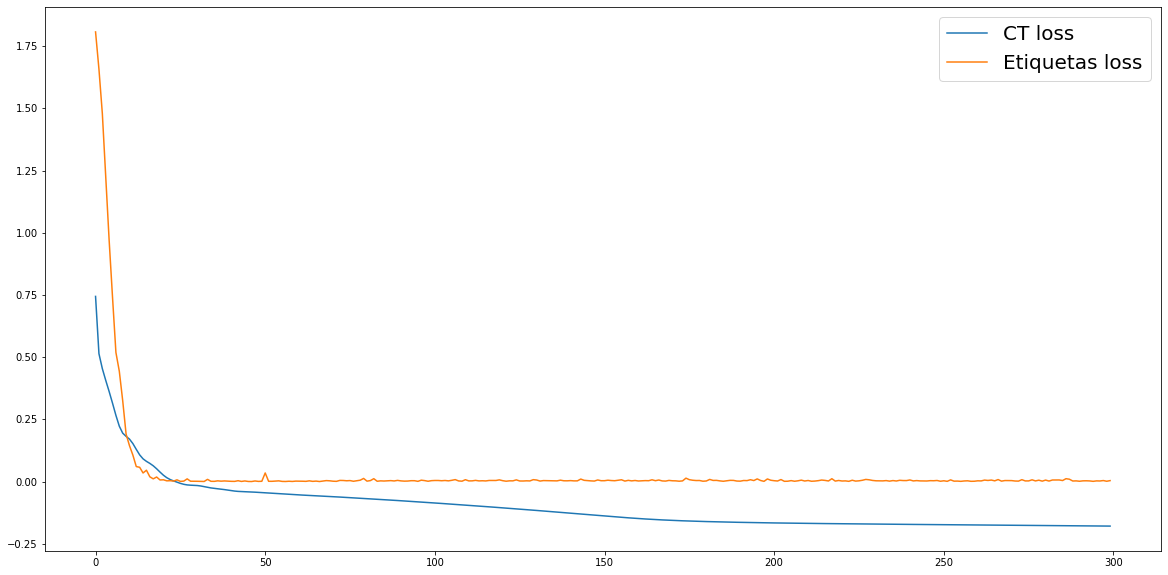

In [21]:
from utils import train,val,test
import matplotlib.pyplot as plt
model = ODwire(in_channels=dataset.num_features,
                                hidden_channels=32,
                                num_centers=3,
                                adj_dim = adj.shape[0],
                                n_layers= 2,
                                out_channels=dataset.num_classes).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
test_acc = 0
cts = []
etiquetas = []
adjs_in_real_time_supervised = []
embeddings_supervised = []
gnn_out_supervised = []
best_model = None
for epoch in range(300):
    loss,acc_train,ct_loss,etiqueta,_ = train(adj,data,model,train_mask,optimizer,criterion)
    gnn_out_supervised.append(model.gnn_out.detach().cpu().clone().numpy())
    adjs_in_real_time_supervised.append(model.new_adj.detach().cpu().clone().numpy())
    embeddings_supervised.append(model.embeddings.detach().cpu().clone().numpy())
    cts.append(ct_loss.detach().cpu().numpy())
    etiquetas.append(etiqueta.detach().cpu().numpy())
    acc_val = val(adj,data,model,val_mask)
    acc_test = test(adj,data,model,test_mask)
    if acc_test > test_acc:
        test_acc = acc_test
        # We save the model
        best_model = torch.save(model.state_dict(), 'best_model.pth')
        z = model.gnn_out.squeeze(0).detach().cpu()
        print("The best iterarion is: ",epoch)
    # Now let's assign for every node of z the corresponding cluster using kmeans
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
    #kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
    # Let's plot the kmeans over the embedding
    #tsne = TSNE(n_components=2, random_state=123)#,init='pca',learning_rate=200.0)
    #tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
    #plt.figure(figsize=(20,10))
    #plt.title('Epoch: {}, Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}, Test Acc: {:.4f}'.format(epoch,loss,acc_train,acc_val,acc_test),fontsize=20)
    #sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y,palette='viridis')
    #plt.show()

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}, Test Acc: {acc_test:.4f}')
print('===========================================================================================================')
print('Test Accuracy: ',test_acc)
print('===========================================================================================================')
# Let's plot the loss
plt.figure(figsize=(20,10))
plt.plot(cts,label='CT loss')
plt.plot(etiquetas,label='Etiquetas loss')
plt.legend(fontsize=20)
plt.show()

In [22]:
g_malo = torch.sigmoid(torch.tensor(gnn_out_supervised[0])@torch.tensor(gnn_out_supervised[0]).t())
G_malo = nx.from_numpy_matrix(g_malo.detach().cpu().numpy())
 

In [23]:
# Leemos el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))
best_model = model
# Le pasamos el mejor modelo a la función de test
acc_test = test(adj,data,best_model,test_mask)
print('===========================================================================================================')
print('Test Accuracy: ',acc_test)
print('===========================================================================================================')

Test Accuracy:  0.6666666666666666


In [24]:
from torchviz import make_dot
embeddings = best_model.gnn_out.cpu()
make_dot(model.gnn_out, params=dict(model.named_parameters())).view()

'Digraph.gv.pdf'

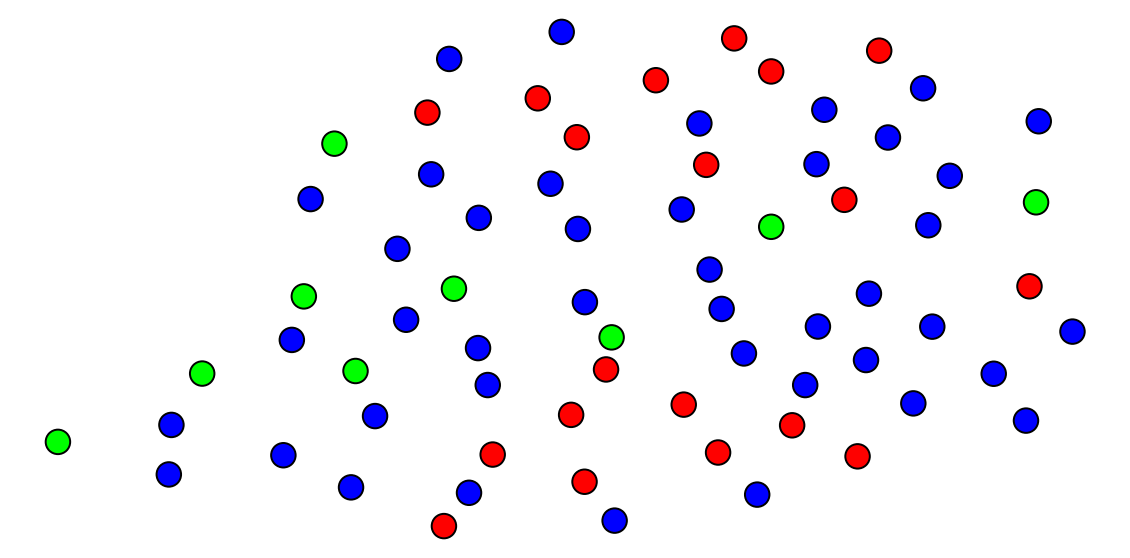

In [8]:
# Import tsne 
from sklearn.manifold import TSNE
# Let's plot the embeddings
plt.figure(figsize=(20,10))
tsne = TSNE(n_components=2, random_state=101)#,init='pca',learning_rate=200.0)
tsne_obj = tsne.fit_transform(gnn_out_supervised[1])
# Intercambiamos los siguientes nodos:
# 58 -> 32
#tsne_obj[58],tsne_obj[32] = tsne_obj[32],tsne_obj[58]
# 32 -> 52
#tsne_obj[32],tsne_obj[52] = tsne_obj[52],tsne_obj[32]
# 13 -> 35
#tsne_obj[13],tsne_obj[35] = tsne_obj[35],tsne_obj[13]
# Con puntos más grandes y con bordes más oscuros
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=600,hue=data.y,palette='brg',edgecolor='black',alpha=1)
# Pintamos en cada punto el número de nodo
#for i in range(len(data.y)):
    #plt.text(tsne_obj[i,0],tsne_obj[i,1],str(i),fontsize=20)
# plot a link between the embeddings with the same label
#for i in range(len(data.y)):
    #for j in range(len(data.y)):
        #if data.y[i] == data.y[j]:
            #plt.plot([tsne_obj[i,0],tsne_obj[j,0]],[tsne_obj[i,1],tsne_obj[j,1]],'-',color='black',alpha=0.1)
# Deactivamos los ejes 
plt.axis('off')
# No mostramos la leyenda
plt.legend([],[], frameon=False)
plt.show()

In [9]:
'''# Creamos un gif con las adyacencias
import imageio
images = []
for i in range(len(adjs_in_real_time)):
    plt.figure(figsize=(15,7))
    plt.imshow(adjs_in_real_time[i],cmap='hot')
    plt.title(f'Epoch {i}')
    plt.savefig(f'./images_supervised/epoch_{i}.png')
    plt.close()
    images.append(imageio.imread(f'./images_supervised/epoch_{i}.png'))
imageio.mimsave('./images_supervised/movie.gif', images, fps=25)
'''

"#\xa0Creamos un gif con las adyacencias\nimport imageio\nimages = []\nfor i in range(len(adjs_in_real_time)):\n    plt.figure(figsize=(15,7))\n    plt.imshow(adjs_in_real_time[i],cmap='hot')\n    plt.title(f'Epoch {i}')\n    plt.savefig(f'./images_supervised/epoch_{i}.png')\n    plt.close()\n    images.append(imageio.imread(f'./images_supervised/epoch_{i}.png'))\nimageio.mimsave('./images_supervised/movie.gif', images, fps=25)\n"

torch.Size([70, 3])
torch.Size([70, 70])
torch.Size([70, 70])
tensor([0.8026, 0.9131, 0.9288])
Autovalores tensor([0.8026, 0.9131, 0.9288])
torch.Size([70, 70])


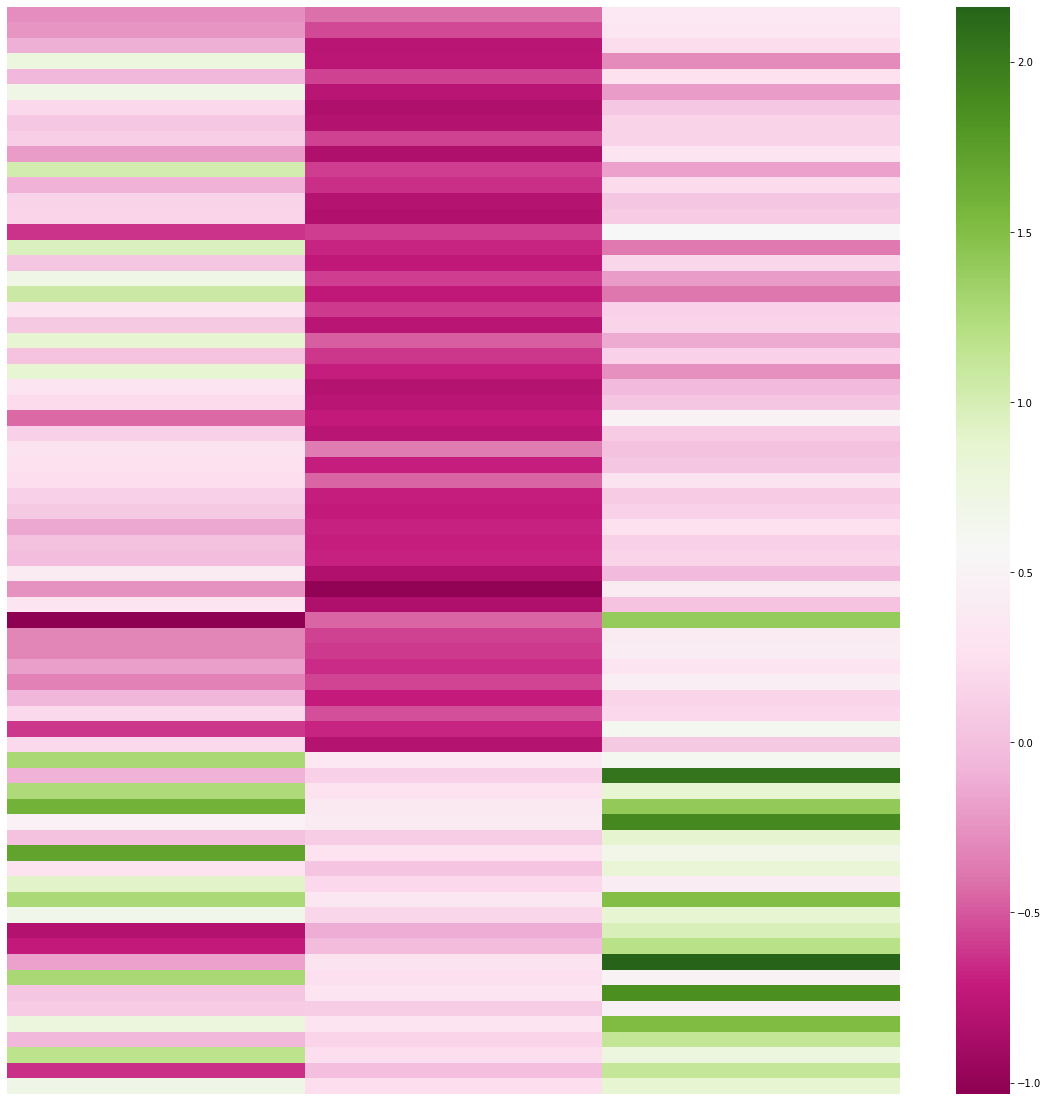

In [10]:
import seaborn as sns
embeddings = best_model.embeddings.squeeze(0).detach().cpu()
print(embeddings.shape)
# Get the degree matrix of adj  
d = torch.sum(adj.squeeze(0), dim=1)
# put it in the diagonal of a matrix
D = torch.diag(d)
print(D.shape)
# Compute the Laplacian
L = D - adj.squeeze(0)
print(L.shape)
# Compute the eigen values
#eign = embeddings.T @ L @ embeddings
CT_num = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1),adj.squeeze(0)), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
CT_den = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1), D), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
print(CT_num/CT_den)    
diagonal_eign = CT_num/CT_den
# Now sort the eigen values
_, indices = torch.sort(diagonal_eign, descending=False)
# Sort the embeddings
embeddings = embeddings[:, indices]
# And the eigen values
diagonal_eign = torch.sort(diagonal_eign, descending=False)[0]
print("Autovalores",diagonal_eign)
print(L.shape)
plt.figure(figsize=(20,20))
sns.heatmap(embeddings.numpy(), cmap='PiYG', xticklabels=False, yticklabels=False)
plt.show()

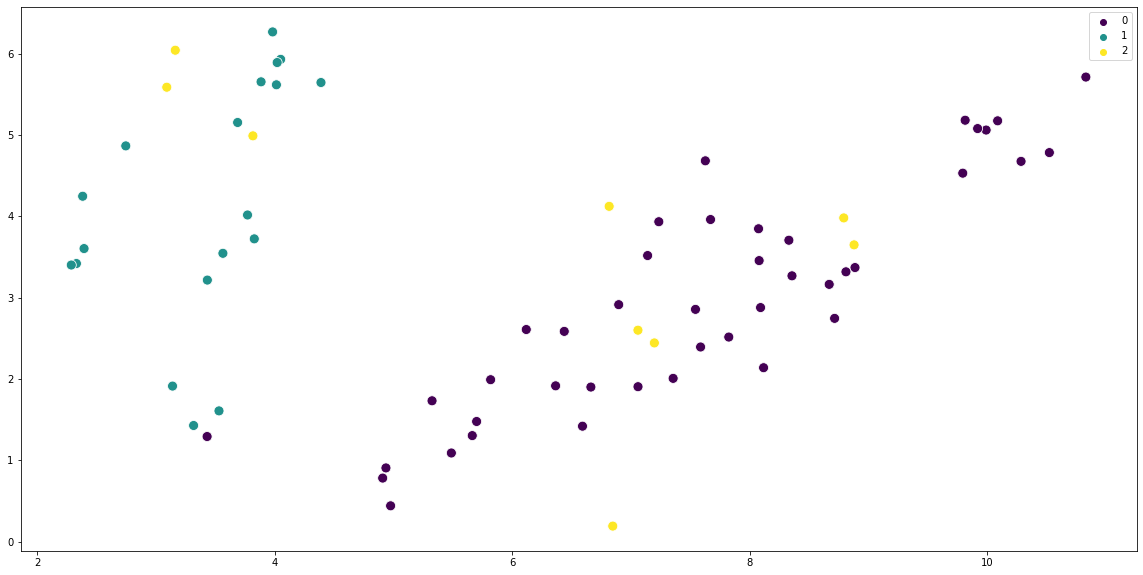

In [11]:
z = best_model.embeddings.squeeze(0).detach().cpu()
# Now let's assign for every node of z the corresponding cluster using kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
#kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
# Let's plot the kmeans over the embedding
tsne = TSNE(n_components=2, random_state=123)#,init='pca',learning_rate=200.0)
tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
plt.figure(figsize=(20,10))
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y[:],palette='viridis')
plt.show()


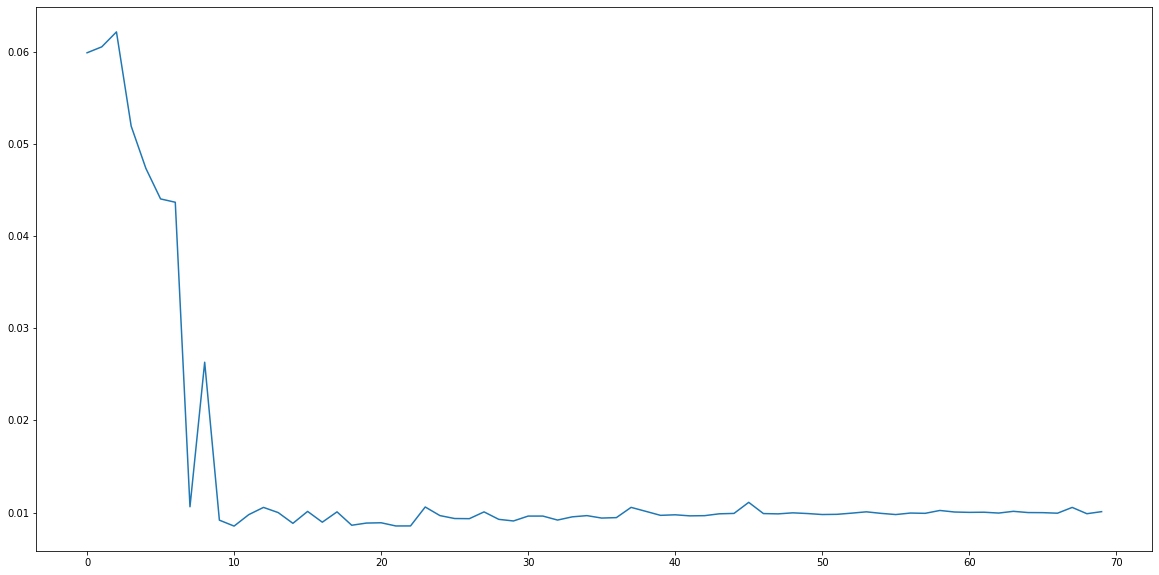

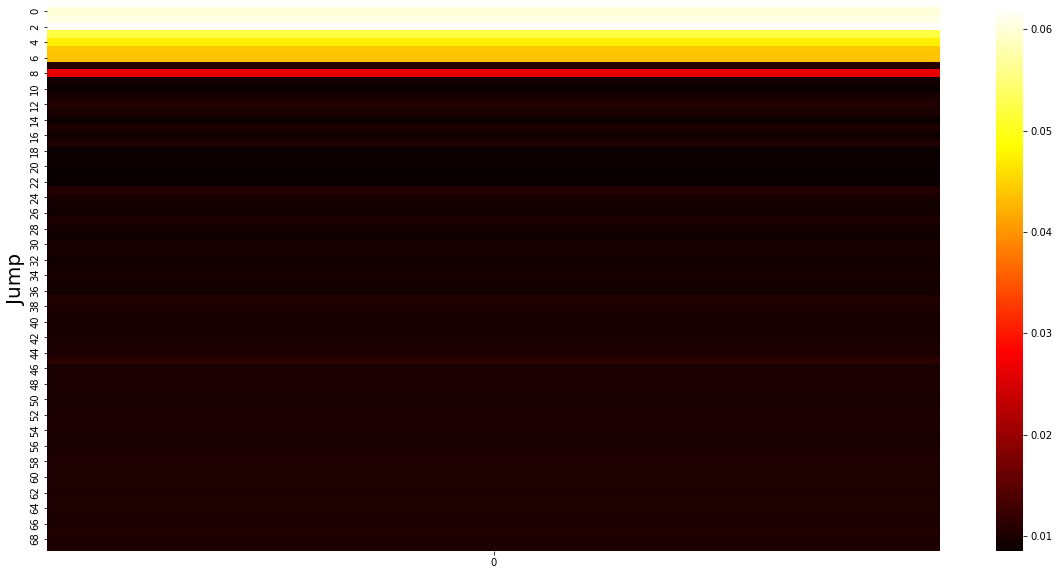

In [12]:
alfas = torch.softmax(model.att, dim=0).unsqueeze(1).detach().cpu().numpy()
# Parse alfas to a 2D matrix
# Plot the alphas
plt.figure(figsize=(20,10))
plt.plot(alfas)
plt.show()
# Now plot as an image
plt.figure(figsize=(20,10))
sns.heatmap(alfas, cmap='hot')
plt.ylabel('Jump', fontsize=20)
plt.show()

In [13]:
# Now let's plot all the khops
new_adj_rewired = best_model.new_adj.detach().cpu()
previous_adj = torch.zeros_like(new_adj_rewired)
adjs = []
for i in range(40):
    adj = torch.zeros_like(new_adj_rewired)
    top_min = torch.topk(new_adj_rewired, i, dim=1, largest=False, sorted=True)
    adj.scatter_(1, top_min.indices, 1)
    adj = adj - previous_adj
    # if there is any negative value, replace it with 0
    adj[adj < 0] = 0
    adjs.append(adj.numpy())
    previous_adj = adj

In [14]:
'''# Now let's plot all the khops
fig, axs = plt.subplots(40,1,figsize=(20,200))
for f in range(40):
    # Parse the adj to a networkx graph
    G = nx.from_numpy_matrix(adjs[f])
    for i in range(len(sizes)):
        for j in range(sizes[i]):
            G.nodes[j+i*35]['color'] = i
    pos = nx.spring_layout(G,seed=1234)
    plt.figure(figsize=(15,7))
    #draw nodes with mapped color
    nx.draw(G,
            pos=pos,
            node_color= data.y,
            edge_color='black',
            width=0.55,
            style='solid',
            linewidths=1,
            cmap=plt.cm.viridis,
            #node_size=100,
            with_labels=False,
            alpha=1,
            ax=axs[f])
    axs[f].set_title(f'k={f+1}')
plt.show()'''

"#\xa0Now let's plot all the khops\nfig, axs = plt.subplots(40,1,figsize=(20,200))\nfor f in range(40):\n    #\xa0Parse the adj to a networkx graph\n    G = nx.from_numpy_matrix(adjs[f])\n    for i in range(len(sizes)):\n        for j in range(sizes[i]):\n            G.nodes[j+i*35]['color'] = i\n    pos = nx.spring_layout(G,seed=1234)\n    plt.figure(figsize=(15,7))\n    #draw nodes with mapped color\n    nx.draw(G,\n            pos=pos,\n            node_color= data.y,\n            edge_color='black',\n            width=0.55,\n            style='solid',\n            linewidths=1,\n            cmap=plt.cm.viridis,\n            #node_size=100,\n            with_labels=False,\n            alpha=1,\n            ax=axs[f])\n    axs[f].set_title(f'k={f+1}')\nplt.show()"

In [15]:
class ODwire_unsupervised(torch.nn.Module):
    def __init__(self, in_channels, adj_dim, hidden_channels, num_centers):
        super(ODwire_unsupervised, self).__init__()
        torch.manual_seed(1234)
        # CT-Layer
        self.MLP_adj = Linear(adj_dim, num_centers)
        self.embedding = None
    def forward(self, x, adj):
        s = self.MLP_adj(adj)
        self.embedding = s
        _, CT_loss, ortho_loss, new_adj= dense_OD_rewiring(x, adj, s, mask=None)
        return s, CT_loss + ortho_loss, new_adj

70
Epoch: 000, Loss: 1.5735
Epoch: 001, Loss: 1.3798
Epoch: 002, Loss: 1.2696
Epoch: 003, Loss: 1.2056
Epoch: 004, Loss: 1.1599
Epoch: 005, Loss: 1.1236
Epoch: 006, Loss: 1.0934
Epoch: 007, Loss: 1.0669
Epoch: 008, Loss: 1.0438
Epoch: 009, Loss: 1.0242
Epoch: 010, Loss: 1.0066
Epoch: 011, Loss: 0.9902
Epoch: 012, Loss: 0.9750
Epoch: 013, Loss: 0.9615
Epoch: 014, Loss: 0.9499
Epoch: 015, Loss: 0.9392
Epoch: 016, Loss: 0.9288
Epoch: 017, Loss: 0.9187
Epoch: 018, Loss: 0.9088
Epoch: 019, Loss: 0.8989
Epoch: 020, Loss: 0.8892
Epoch: 021, Loss: 0.8803
Epoch: 022, Loss: 0.8726
Epoch: 023, Loss: 0.8664
Epoch: 024, Loss: 0.8615
Epoch: 025, Loss: 0.8574
Epoch: 026, Loss: 0.8540
Epoch: 027, Loss: 0.8511
Epoch: 028, Loss: 0.8485
Epoch: 029, Loss: 0.8461
Epoch: 030, Loss: 0.8438
Epoch: 031, Loss: 0.8414
Epoch: 032, Loss: 0.8390
Epoch: 033, Loss: 0.8365
Epoch: 034, Loss: 0.8341
Epoch: 035, Loss: 0.8317
Epoch: 036, Loss: 0.8293
Epoch: 037, Loss: 0.8271
Epoch: 038, Loss: 0.8251
Epoch: 039, Loss: 0.82

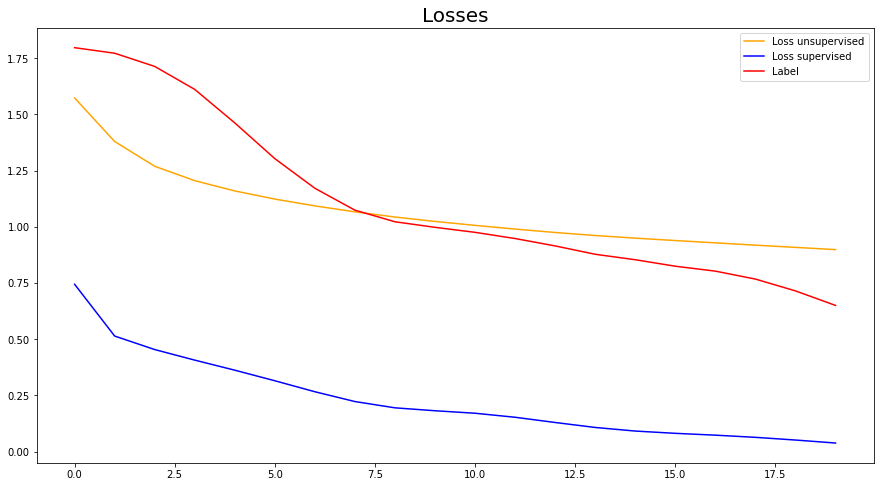

In [16]:
adj = to_dense_adj(data.edge_index)[0].to(device)
from utils import train_adj
print(adj.shape[0])
unsupervised_model = ODwire_unsupervised(in_channels=dataset.num_features,
                                            adj_dim=adj.shape[0],
                                            hidden_channels=0,                            
                                            num_centers=6).to(device)
unsupervised_model.train()   
optimizer = torch.optim.Adam(unsupervised_model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []
adjs_in_real_time = []
embeddings_non_supervised = []
for epoch in range(300):
    loss , new_adj = train_adj(adj,data,unsupervised_model,optimizer)
    embeddings_non_supervised.append(unsupervised_model.embedding.detach().cpu())
    losses.append(loss.item())
    new_adj = new_adj.detach().squeeze(0).to('cpu')
    adjs_in_real_time.append(new_adj)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print('===========================================================================================================')
print('Final loss: ',loss.item())
print('===========================================================================================================')
adj_re = new_adj.detach().squeeze(0)#.numpy()
plt.figure(figsize=(15,8))
# Plot the losses
cts_list = [x.item() for x in cts]
etiquetas_list = [x.item() for x in etiquetas]
sns.lineplot(x=range(20),y=losses[:20],color='orange',label='Loss unsupervised')
sns.lineplot(y=cts_list[:20],color='blue',label='Loss supervised',x=range(20))
sns.lineplot(x=range(20),y=etiquetas_list[:20],color='red',label='Label')
plt.title('Losses',fontsize=20)
plt.show()

In [17]:
# COmpare the embeddings
#print("The difference between the embeddings is: ",torch.norm(embeddings_non_supervised[-1]-embeddings_supervised[-1]))

In [18]:
'''# Creamos un gif con las adyacencias
import imageio
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1234)
images = []
for i in range(len(adjs_in_real_time)):
    plt.figure(figsize=(15,8))
    # Global title
    plt.suptitle(f'Epoch: {i}',fontsize=20)
    # Dont show colorbar in subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    X_2d = tsne.fit_transform(embeddings_non_supervised[i])
    plt.subplot(1,2,1)
    plt.title('Unsupervised',fontsize=20)
    sns.scatterplot(x=X_2d[:48,0],y=X_2d[:48,1],hue=data.y[:48],palette='viridis',legend=False)
    plt.axis('off')
    # Plot in two subplots
    
    plt.subplot(1,2,2)
    plt.title('Supervised',fontsize=20)
    X_2d = tsne.fit_transform(embeddings_supervised[i])
    sns.scatterplot(x=X_2d[:48,0],y=X_2d[:48,1],hue=data.y[:48],palette='viridis',legend=False)
    plt.axis('off')
    # Dont show colorbar in subplots
    plt.savefig(f'./embeddings/embeddings{i}.png')
    images.append(imageio.imread(f'./embeddings/embeddings{i}.png'))
    plt.close()
imageio.mimsave('./embeddings/movie.gif', images, fps=5)
'''

"#\xa0Creamos un gif con las adyacencias\nimport imageio\nfrom sklearn.manifold import TSNE\ntsne = TSNE(n_components=2, random_state=1234)\nimages = []\nfor i in range(len(adjs_in_real_time)):\n    plt.figure(figsize=(15,8))\n    # Global title\n    plt.suptitle(f'Epoch: {i}',fontsize=20)\n    #\xa0Dont show colorbar in subplots\n    plt.subplots_adjust(wspace=0.1, hspace=0.1)\n    \n    X_2d = tsne.fit_transform(embeddings_non_supervised[i])\n    plt.subplot(1,2,1)\n    plt.title('Unsupervised',fontsize=20)\n    sns.scatterplot(x=X_2d[:48,0],y=X_2d[:48,1],hue=data.y[:48],palette='viridis',legend=False)\n    plt.axis('off')\n    #\xa0Plot in two subplots\n    \n    plt.subplot(1,2,2)\n    plt.title('Supervised',fontsize=20)\n    X_2d = tsne.fit_transform(embeddings_supervised[i])\n    sns.scatterplot(x=X_2d[:48,0],y=X_2d[:48,1],hue=data.y[:48],palette='viridis',legend=False)\n    plt.axis('off')\n    #\xa0Dont show colorbar in subplots\n    plt.savefig(f'./embeddings/embeddings{i}.png

In [19]:
'''# Creamos un gif con las adyacencias
import imageio
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1234)
images = []
for i in range(len(adjs_in_real_time)):
    images.append(imageio.imread(f'./embeddings/embeddings{i}.png'))
    plt.close()
imageio.mimsave('./embeddings/movie.gif', images, fps=5)
'''

"#\xa0Creamos un gif con las adyacencias\nimport imageio\nfrom sklearn.manifold import TSNE\ntsne = TSNE(n_components=2, random_state=1234)\nimages = []\nfor i in range(len(adjs_in_real_time)):\n    images.append(imageio.imread(f'./embeddings/embeddings{i}.png'))\n    plt.close()\nimageio.mimsave('./embeddings/movie.gif', images, fps=5)\n"

In [20]:
# Creamos un gif con las adyacencias

'''import imageio
images = []
for i in range(len(adjs_in_real_time)):
    plt.figure(figsize=(15,8))
    # Global title
    plt.suptitle(f'Epoch: {i}',fontsize=20)
    # Dont show colorbar in subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.axis('off')
    # Plot in two subplots
    plt.subplot(1,2,1)
    plt.title('Unsupervised',fontsize=20)
    plt.imshow(adjs_in_real_time[i],cmap='hot')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Supervised',fontsize=20)
    plt.imshow(adjs_in_real_time_supervised[i],cmap='hot')
    plt.axis('off')
    # Dont show colorbar in subplots
    plt.savefig(f'./images/adj_{i}.png')
    images.append(imageio.imread(f'./images/adj_{i}.png'))
    plt.close()
imageio.mimsave('./images/movie.gif', images, fps=25)'''

"import imageio\nimages = []\nfor i in range(len(adjs_in_real_time)):\n    plt.figure(figsize=(15,8))\n    # Global title\n    plt.suptitle(f'Epoch: {i}',fontsize=20)\n    #\xa0Dont show colorbar in subplots\n    plt.subplots_adjust(wspace=0.1, hspace=0.1)\n    plt.axis('off')\n    #\xa0Plot in two subplots\n    plt.subplot(1,2,1)\n    plt.title('Unsupervised',fontsize=20)\n    plt.imshow(adjs_in_real_time[i],cmap='hot')\n    plt.axis('off')\n    \n    plt.subplot(1,2,2)\n    plt.title('Supervised',fontsize=20)\n    plt.imshow(adjs_in_real_time_supervised[i],cmap='hot')\n    plt.axis('off')\n    #\xa0Dont show colorbar in subplots\n    plt.savefig(f'./images/adj_{i}.png')\n    images.append(imageio.imread(f'./images/adj_{i}.png'))\n    plt.close()\nimageio.mimsave('./images/movie.gif', images, fps=25)"

In [21]:
# Vamos a sacar tantos topk, como n_layers
edge_indexs = []
#edge_indexs.append(data.edge_index.to('cpu').clone())
#adj_re = torch.from_numpy(adj_re).to('cpu')
previus_adj = torch.zeros(adj_re.shape).to('cpu')
for i in range(60):
    adj_j = torch.zeros_like(adj_re)
    top_min = torch.topk(torch.tensor(adjs_in_real_time_supervised[70]), i, dim=1, largest=False, sorted=True)
    adj_j.scatter_(1, top_min.indices, top_min.values)
    adj_j = adj_j - previus_adj
    # if some value is negative, we put it to 0
    adj_j[adj_j<0] = 0
    edge_indexs.append(adj_j)
    print("Shape of the new adj in layer ",i,": ",edge_indexs[i].shape)
    previus_adj = adj_j
#del unsupervised_model
del adj
del adj_j
del previus_adj


Shape of the new adj in layer  0 :  torch.Size([70, 70])
Shape of the new adj in layer  1 :  torch.Size([70, 70])
Shape of the new adj in layer  2 :  torch.Size([70, 70])
Shape of the new adj in layer  3 :  torch.Size([70, 70])
Shape of the new adj in layer  4 :  torch.Size([70, 70])
Shape of the new adj in layer  5 :  torch.Size([70, 70])
Shape of the new adj in layer  6 :  torch.Size([70, 70])
Shape of the new adj in layer  7 :  torch.Size([70, 70])
Shape of the new adj in layer  8 :  torch.Size([70, 70])
Shape of the new adj in layer  9 :  torch.Size([70, 70])
Shape of the new adj in layer  10 :  torch.Size([70, 70])
Shape of the new adj in layer  11 :  torch.Size([70, 70])
Shape of the new adj in layer  12 :  torch.Size([70, 70])
Shape of the new adj in layer  13 :  torch.Size([70, 70])
Shape of the new adj in layer  14 :  torch.Size([70, 70])
Shape of the new adj in layer  15 :  torch.Size([70, 70])
Shape of the new adj in layer  16 :  torch.Size([70, 70])
Shape of the new adj in 

In [22]:
# Obtenemos la matriz de adyacencia
'''import imageio
images = []
for i in range(60):
    print("Plotting layer: ",i)
    adj = edge_indexs[i].numpy()
    # Hacemos el mismo plot pero usando Plotly
    import plotly.graph_objects as go
    # Vamos a hacer una superficie interpolando los valores de la matriz de adyacencia
    # Creamos una figura
    from scipy.interpolate import griddata
    import numpy as np
    import scipy.ndimage
    sigma = [4, 4]
    depth_smooth = scipy.ndimage.filters.gaussian_filter(adj, sigma)
    fig = go.Figure(data=[go.Surface(z=depth_smooth)])
    fig.update_layout(title=None, autosize=False,

                        width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
    # No mostramos los ejes
    fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False),
                                    yaxis = dict(title='',showticklabels=False),
                                    zaxis = dict(title='',showticklabels=False)))
    # No mostramos el fondo
    fig.update_layout(scene = dict(
                        xaxis = dict(showbackground=False),
                        yaxis = dict(showbackground=False),
                        zaxis = dict(showbackground=False)))
    # Cambiamos el heatmap
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                        highlightcolor="limegreen", project_z=True))
    # Cambiamos el mapa de colores
    fig.update_traces(colorscale='hot')
    # No mostramos el colorbar
    fig.update_layout(coloraxis_showscale=False)
    # Cambiamos la orientacion de la camara para verlo desde arriba y un poco de lado
    fig.update_layout(scene_camera=dict(eye=dict(x=-1.25, y=-1.25, z=1.25)))
    # Mostramos los picos curvos
    puntos = edge_indexs[2].nonzero()
    # Vamos a pintar los puntos de amarillo sobre la superficie
    fig.add_trace(go.Scatter3d(x=puntos[0], y=puntos[1], z=puntos[0]*0, mode='markers',marker=dict(size=5,color='yellow')))
    # Guardamos la imagen
    fig.write_image(f"./images/adj_{i}.png")
    imageio.imread(f'./images/adj_{i}.png')
    images.append(imageio.imread(f'./images/adj_{i}.png'))
imageio.mimsave('./images/movie.gif', images, fps=8)
    '''

'import imageio\nimages = []\nfor i in range(60):\n    print("Plotting layer: ",i)\n    adj = edge_indexs[i].numpy()\n    #\xa0Hacemos el mismo plot pero usando Plotly\n    import plotly.graph_objects as go\n    #\xa0Vamos a hacer una superficie interpolando los valores de la matriz de adyacencia\n    #\xa0Creamos una figura\n    from scipy.interpolate import griddata\n    import numpy as np\n    import scipy.ndimage\n    sigma = [4, 4]\n    depth_smooth = scipy.ndimage.filters.gaussian_filter(adj, sigma)\n    fig = go.Figure(data=[go.Surface(z=depth_smooth)])\n    fig.update_layout(title=None, autosize=False,\n\n                        width=500, height=500,\n                        margin=dict(l=65, r=50, b=65, t=90))\n    #\xa0No mostramos los ejes\n    fig.update_layout(scene = dict( xaxis = dict(title=\'\',showticklabels=False),\n                                    yaxis = dict(title=\'\',showticklabels=False),\n                                    zaxis = dict(title=\'\',showtickl

In [23]:
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# Obtenemos la matriz de adyacencia
import imageio
images = []
for i in [4]:
    print("Plotting layer: ",i)
    adj = adjs_in_real_time_supervised[70]
    #adj = edge_indexs[i]
    adj = torch.tensor(adj)
    adj = torch.exp(-adj).numpy()
    #adj = to_dense_adj(data.edge_index).squeeze(0).numpy()
    # Hacemos el mismo plot pero usando Plotly
    # Vamos a hacer una superficie interpolando los valores de la matriz de adyacencia
    # Creamos una figura
    from scipy.interpolate import griddata
    import numpy as np
    import scipy.ndimage
    sigma = [2.5, 2.5]
    depth_smooth = scipy.ndimage.filters.gaussian_filter(adj, sigma)
    fig = go.Figure(data=[go.Surface(z=depth_smooth)])
    fig.update_layout(title=None, autosize=False,

                        width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
    # No mostramos los ejes
    fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False),
                                    yaxis = dict(title='',showticklabels=False),
                                    zaxis = dict(title='',showticklabels=False)))
    # No mostramos el fondo
    fig.update_layout(scene = dict(
                        xaxis = dict(showbackground=False),
                        yaxis = dict(showbackground=False),
                        zaxis = dict(showbackground=False)))
    # Cambiamos el heatmap
    fig.update_traces(contours_z=dict(show=False, usecolormap=True,
                                        highlightcolor="limegreen", project_z=True))
    # Mostramos el countour
    #fig.update_traces(contours_z=dict(show=True, usecolormap=True,
    #                                   highlightcolor="limegreen", project_z=True))
    
    # Cambiamos el mapa de colores
    fig.update_traces(colorscale='Bluered')
    # No mostramos el colorbar
    fig.update_layout(coloraxis_showscale=False)
    # Cambiamos la orientacion de la camara para verlo desde arriba y un poco de lado
    fig.update_layout(scene_camera=dict(eye=dict(x=-1.25, y=-1.25, z=1.25)))
    # Mostramos los picos curvos
    puntos = edge_indexs[8].nonzero()
    #print(puntos)
    depth_smooth = torch.tensor(depth_smooth).numpy()
    # Ocultamos la colorbar
    fig.update_layout(coloraxis_showscale=False)
    fig.update(layout_showlegend=False)
    fig.update(layout_coloraxis_showscale=False)
    fig.update_traces(showscale=False)
    # Vamos a pintar los puntos de amarillo sobre la superficie
    for i in range(len(puntos)):
        #print(puntos[i][0],puntos[i][1])
        fig.add_trace(go.Scatter3d(x=[puntos[i][0]], y=[puntos[i][1]], z=[depth_smooth[puntos[i][0].item(),puntos[i][1].item()]], mode='markers',marker=dict(size=3,color='yellow',opacity=1)))
    # Mostramos los picos curvos
    # Guardamos la imagen con la mayor resolucion posible
    
config = {
'toImageButtonOptions': {
'format': 'png', # one of png, svg, jpeg, webp
'filename': 'custom_image',
'height': 500,
'width': 700,
'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
}
}
# Mostramos las coordenadas de las prespectivas en el fig.show

fig.show(config=config)

Plotting layer:  4


In [24]:
# Mostramos una cuadricula de edges
import plotly.express as px
fig = px.imshow(edge_indexs[8]>0, color_continuous_scale='gray')
# Inclinamos la imagen
fig.update_layout(scene_camera=dict(eye=dict(x=-1.25, y=-1.25, z=1.25)))
# No mostramos los ejes
fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False,showspikes = False),
                                yaxis = dict(title='',showticklabels=False,showspikes = False),
                                zaxis = dict(title='',showticklabels=False,showspikes = False)))
# Ocultamos la colorbar
fig.update_layout(coloraxis_showscale=False)
fig.update(layout_showlegend=False)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(showscale=False)
# Sacamo la imagen con un poco de inclinacion de la camara
config = {
'toImageButtonOptions': {
'format': 'png', # one of png, svg, jpeg, webp
'filename': 'custom_image',
'height': 500,
'width': 700,
'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
}
}


fig.show(config=config)

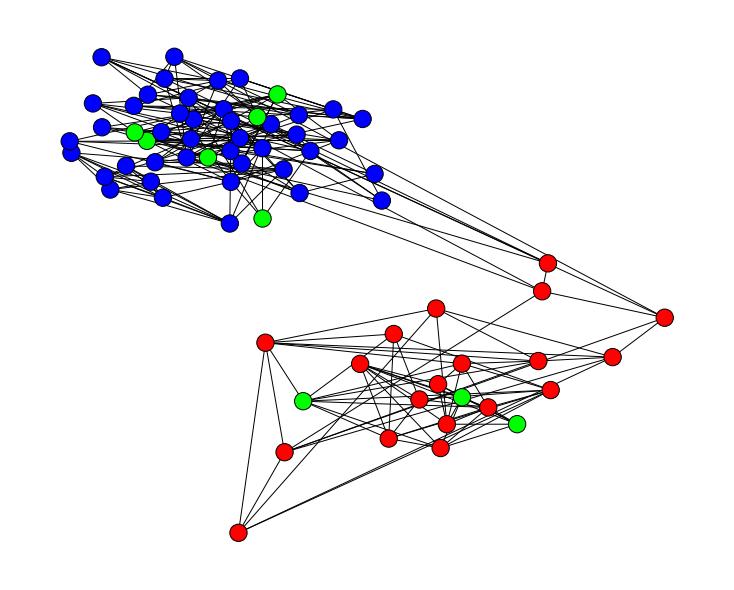

In [52]:
intensidad = (edge_indexs[8]>0).numpy()
g_kk = nx.from_numpy_matrix(intensidad)
plt.figure(figsize=(10,8))
nx.draw(g_kk,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.brg,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black')        


plt.savefig('graph.png', dpi=600)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


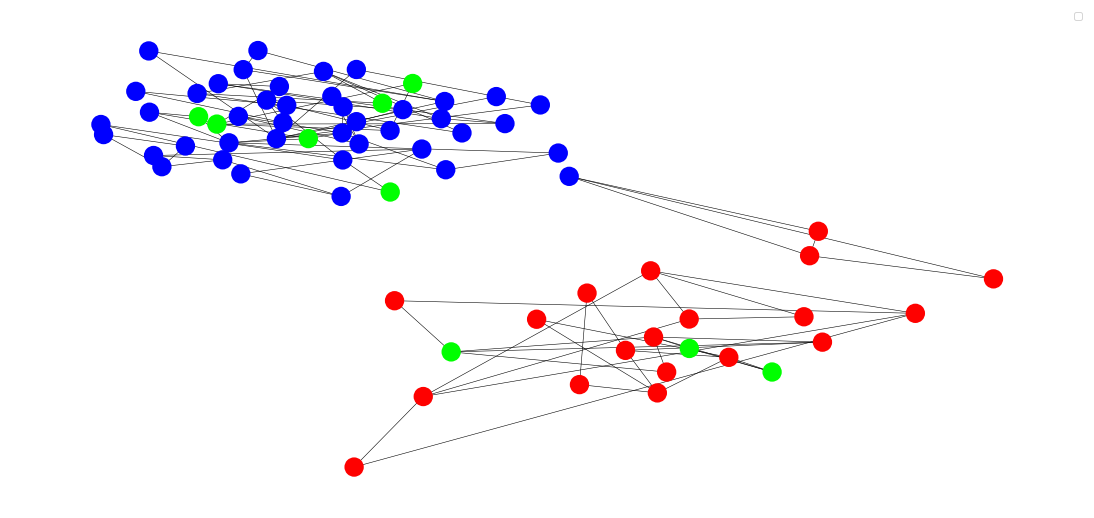

In [46]:
# Pasamos a grafo
adj = (edge_indexs[4]>0).numpy()
# Creamos el grafo
G_final = nx.from_numpy_matrix(adj)
plt.figure(figsize=(15,7))
nx.draw(G_final,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=2,
        cmap=plt.cm.brg,
        #node_size=100,
        with_labels=False,
        alpha=1,
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
plt.legend()
plt.show()

In [33]:
print("Plotting layer: ",i)
adj = edge_indexs[0].numpy()
# Hacemos el mismo plot pero usando Plotly
import plotly.graph_objects as go
# Vamos a hacer una superficie interpolando los valores de la matriz de adyacencia
# Creamos una figura
from scipy.interpolate import griddata
import numpy as np
import scipy.ndimage
sigma = [4, 4]
depth_smooth = scipy.ndimage.filters.gaussian_filter(adj, sigma)
fig = go.Figure(data=[go.Surface(z=depth_smooth)])
fig.update_layout(title=None, autosize=False,

                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))
# No mostramos los ejes
fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False),
                                yaxis = dict(title='',showticklabels=False),
                                zaxis = dict(title='',showticklabels=False)))
# No mostramos el fondo
fig.update_layout(scene = dict(
                    xaxis = dict(showbackground=False),
                    yaxis = dict(showbackground=False),
                    zaxis = dict(showbackground=False)))
# Cambiamos el heatmap
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))
# Cambiamos el mapa de colores
fig.update_traces(colorscale='hot')
# No mostramos el colorbar
fig.update_layout(coloraxis_showscale=False)
# Cambiamos la orientacion de la camara para verlo desde arriba y un poco de lado
fig.update_layout(scene_camera=dict(eye=dict(x=-0.5, y=-0.5, z=2)))
# Mostramos la figura
fig.show()


Plotting layer:  12


In [51]:
class ODwire_supervised(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, n_layers,out_channels,drop_out = 0.5):
        super(ODwire_supervised, self).__init__()
        torch.manual_seed(1234)
        self.convs = torch.nn.ModuleList()
        self.convs.append(DenseGCNConv(in_channels, hidden_channels))
        #Aux
        self.new_adj = None
        self.embeddings = None
        self.gnn_out = None
        self.drop_out = drop_out
        # Parameters
        #self.att = torch.nn.Parameter(torch.ones(n_layers + 1))
        self.att = torch.nn.Parameter(torch.ones(n_layers))
        self.sm = torch.nn.Softmax(dim=0)
        # Linear
        #self.classify1 = Linear(hidden_channels*(n_layers + 1), out_channels)
        self.classify1 = Linear(hidden_channels*n_layers, out_channels)
        # Adjs
    def forward(self, x, adj):
        mask_attentions = self.sm(self.att)
        z_s = []
        for i, conv in enumerate(self.convs):
            #z = conv(x, adj[i + 1].to('cuda:0')).relu() * mask_attentions[i]
            z = conv(x, adj[i].to('cpu').unsqueeze(0)).squeeze(0).relu() * mask_attentions[i]
            z_s.append(z)
        final_z = torch.cat(z_s, dim=1)
        final_z = F.dropout(final_z, p=self.drop_out, training=self.training)
        z = self.classify1(final_z).log_softmax(dim=-1)
        CT_loss = torch.zeros(1).mean()
        self.gnn_out = z
        return z, CT_loss#, CT_loss, adj.detach()

Epoch: 000, Loss: 1.7931, Train Acc: 0.1833, Val Acc: 0.1667, Test Acc: 0.0000
Epoch: 001, Loss: 1.7086, Train Acc: 0.2917, Val Acc: 0.3167, Test Acc: 0.2000
Epoch: 002, Loss: 1.5898, Train Acc: 0.4333, Val Acc: 0.4000, Test Acc: 0.4167
Epoch: 003, Loss: 1.4934, Train Acc: 0.4583, Val Acc: 0.4000, Test Acc: 0.4667
Epoch: 004, Loss: 1.3410, Train Acc: 0.5417, Val Acc: 0.4500, Test Acc: 0.4667
Epoch: 005, Loss: 1.2232, Train Acc: 0.6250, Val Acc: 0.5000, Test Acc: 0.4833
Epoch: 006, Loss: 1.1410, Train Acc: 0.6083, Val Acc: 0.5333, Test Acc: 0.5167
Epoch: 007, Loss: 0.9214, Train Acc: 0.7417, Val Acc: 0.5333, Test Acc: 0.5833
Epoch: 008, Loss: 0.9539, Train Acc: 0.6333, Val Acc: 0.5333, Test Acc: 0.6000
Epoch: 009, Loss: 0.8189, Train Acc: 0.7417, Val Acc: 0.5667, Test Acc: 0.6000
Epoch: 010, Loss: 0.7554, Train Acc: 0.7500, Val Acc: 0.5667, Test Acc: 0.6500
Epoch: 011, Loss: 0.7336, Train Acc: 0.7250, Val Acc: 0.5667, Test Acc: 0.6500
Epoch: 012, Loss: 0.6445, Train Acc: 0.7667, Val Acc

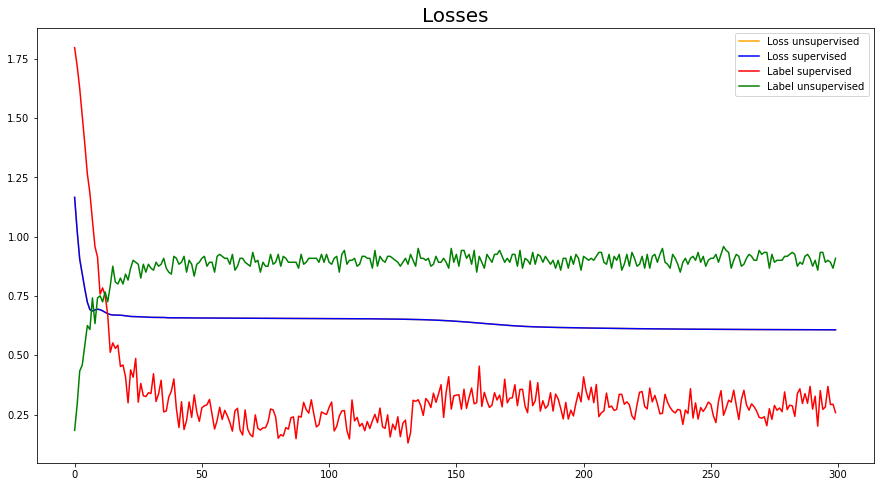

In [53]:

model = ODwire_supervised(in_channels=dataset.num_features,
                                hidden_channels=16,
                                n_layers=1,
                                out_channels=dataset.num_classes,
                                drop_out=0.5).to(device)
    #model = VanillaGCN(in_channels=dataset.num_features,
                                #hidden_channels=args.hidden_channels,
                                #out_channels=dataset.num_classes).to(device)
    
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
test_acc = 0
#adj = edge_indexs[0]
#adj = edge_indexs[0].to(device)
adj = edge_indexs
etiquetas_pochas = []
for epoch in range(300):
    train_mask = train_mask.to(device)
    loss,acc_train,_,_ ,_= train(adj,data,model,train_mask,optimizer,criterion)
    etiquetas_pochas.append(acc_train)
    train_mask = train_mask.to('cpu')
    val_mask = val_mask.to(device)
    acc_val = val(adj,data,model,val_mask)
    val_mask = val_mask.to('cpu')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}, Test Acc: {test_acc:.4f}')
    test_mask = test_mask.to(device)
    acc_test = test(adj,data,model,test_mask)
    test_mask = test_mask.to('cpu')
    if acc_test > test_acc:
        test_acc = acc_test
print('===========================================================================================================')
print('Test Accuracy: ',test_acc)
print('===========================================================================================================')
# Plot the losses
plt.figure(figsize=(15,8))
cts_list = [x.item() for x in cts]
etiquetas_list = [x.item() for x in etiquetas]
sns.lineplot(x=range(len(losses)),y=losses,color='orange',label='Loss unsupervised')
sns.lineplot(y=cts_list,color='blue',label='Loss supervised',x=range(len(losses)))
sns.lineplot(x=range(len(losses)),y=etiquetas_list,color='red',label='Label supervised')
sns.lineplot(x=range(len(losses)),y=etiquetas_pochas,color='green',label='Label unsupervised')
plt.title('Losses',fontsize=20)
plt.show()

In [54]:
# Plot the losses with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(losses)),y=losses,mode='lines',name='Loss unsupervised'))
fig.add_trace(go.Scatter(x=np.arange(len(losses)),y=cts_list,mode='lines',name='Loss supervised'))
fig.add_trace(go.Scatter(x=np.arange(len(losses)),y=etiquetas_list,mode='lines',name='Label supervised'))
fig.add_trace(go.Scatter(x=np.arange(len(losses)),y=etiquetas_pochas,mode='lines',name='Label unsupervised'))
fig.update_layout(title='Losses',xaxis_title='Epochs',yaxis_title='Loss')
fig.show()

torch.Size([240, 6])
torch.Size([240, 240])
torch.Size([240, 240])
tensor([312.8411, 298.0373, 316.7746, 325.7535, 339.8961, 312.9777])
Autovalores tensor([298.0373, 312.8411, 312.9777, 316.7746, 325.7535, 339.8961])
torch.Size([240, 240])


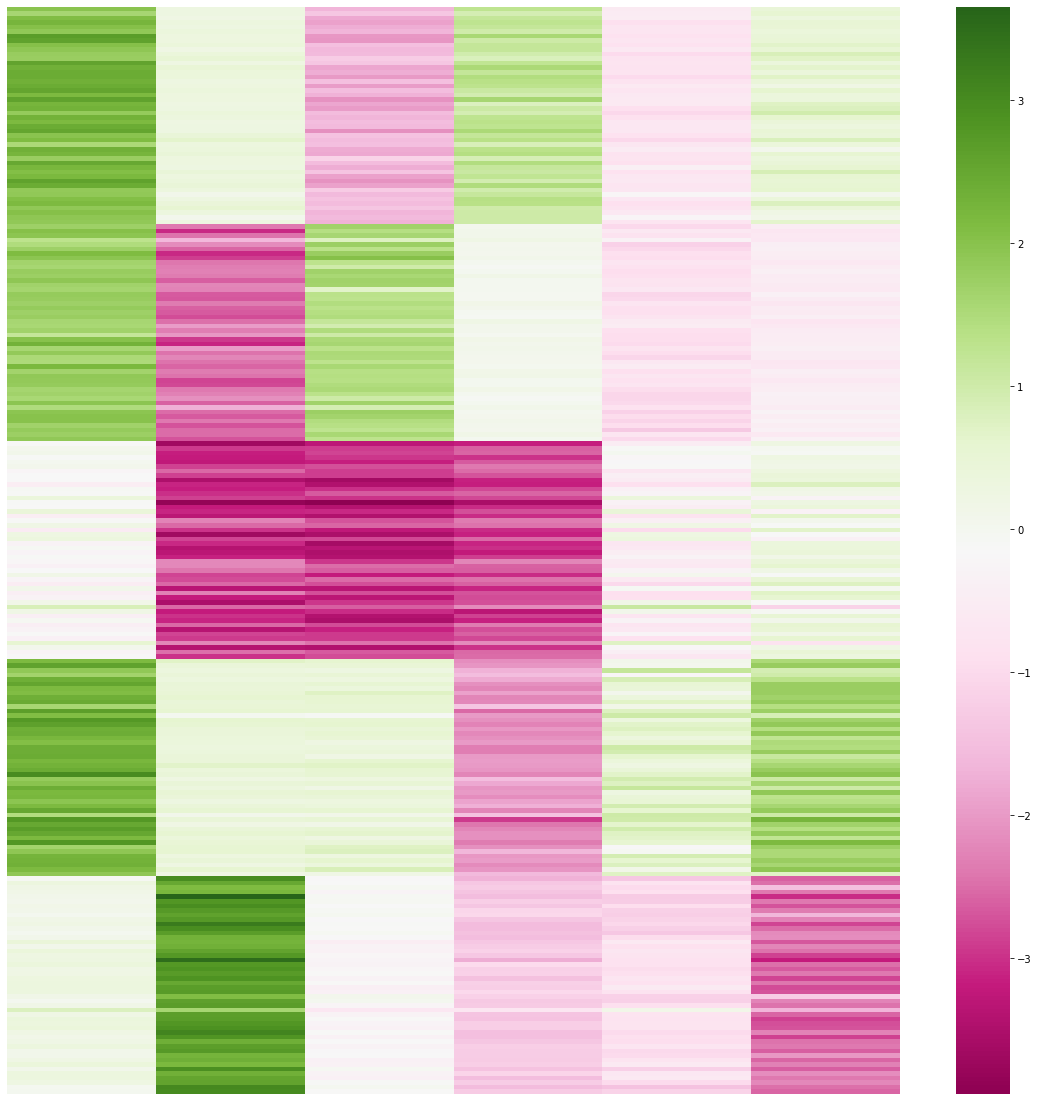

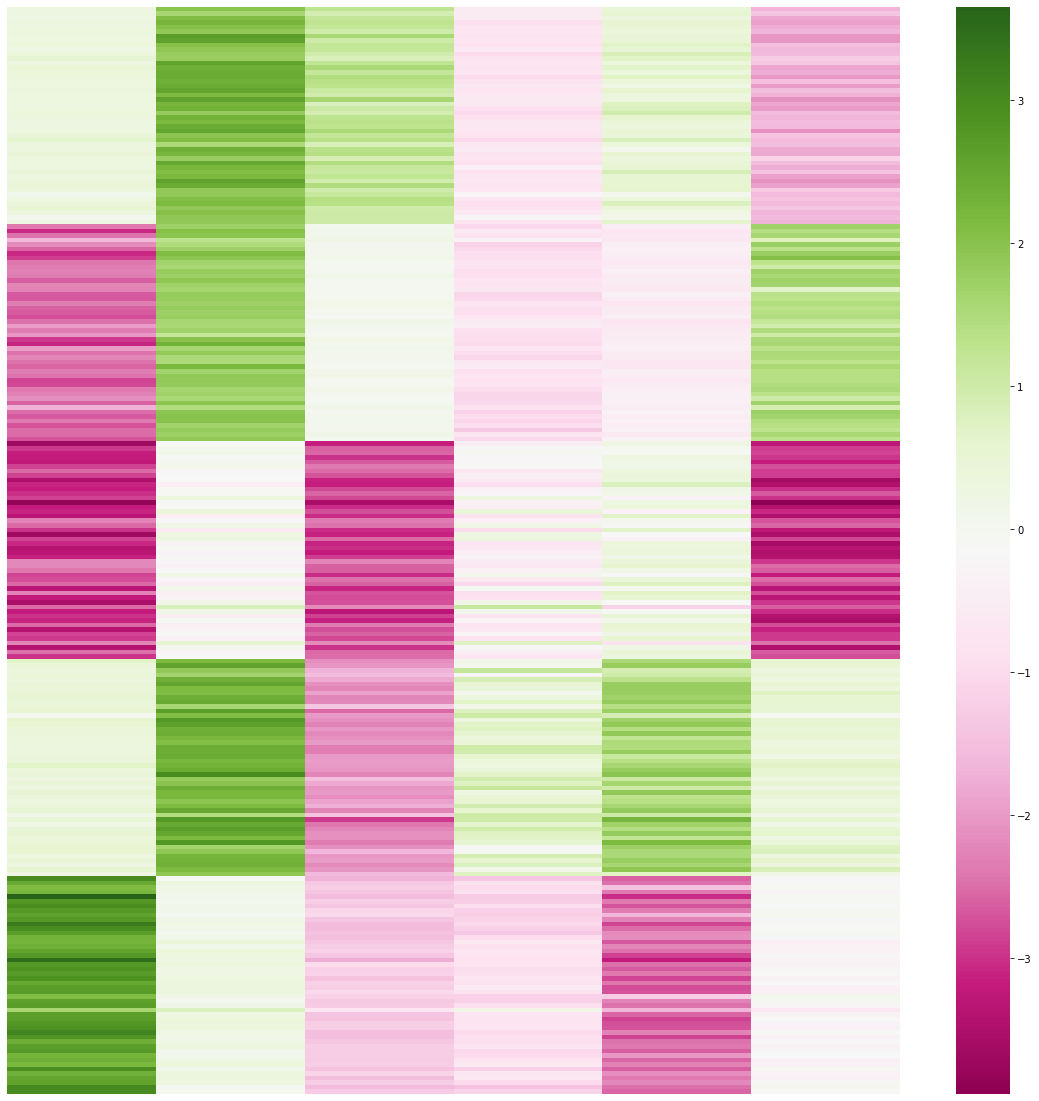

In [60]:
embeddings = unsupervised_model.embedding.squeeze(0).detach().cpu()
print(embeddings.shape)
# Get the degree matrix of adj  
d = torch.sum(adj_re.squeeze(0), dim=1)
# put it in the diagonal of a matrix
D = torch.diag(d)
print(D.shape)
# Compute the Laplacian
L = D - adj_re.squeeze(0)
print(L.shape)
# Compute the eigen values
#eign = embeddings.T @ L @ embeddings
CT_num = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1),to_dense_adj(data.edge_index)[0].to(device)), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
CT_den = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1), D), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
print(CT_num/CT_den)    
diagonal_eign = CT_num/CT_den
# Now sort the eigen values
_, indices = torch.sort(diagonal_eign, descending=False)
# Sort the embeddings
embeddings = embeddings[:, indices]
# And the eigen values
diagonal_eign = torch.sort(diagonal_eign, descending=False)[0]
print("Autovalores",diagonal_eign)
print(L.shape)
plt.figure(figsize=(20,20))
sns.heatmap(embeddings.numpy(), cmap='PiYG', xticklabels=False, yticklabels=False)
plt.show()
embeddings = embeddings_supervised[-1]
plt.figure(figsize=(20,20))
sns.heatmap(embeddings, cmap='PiYG', xticklabels=False, yticklabels=False)
plt.show()

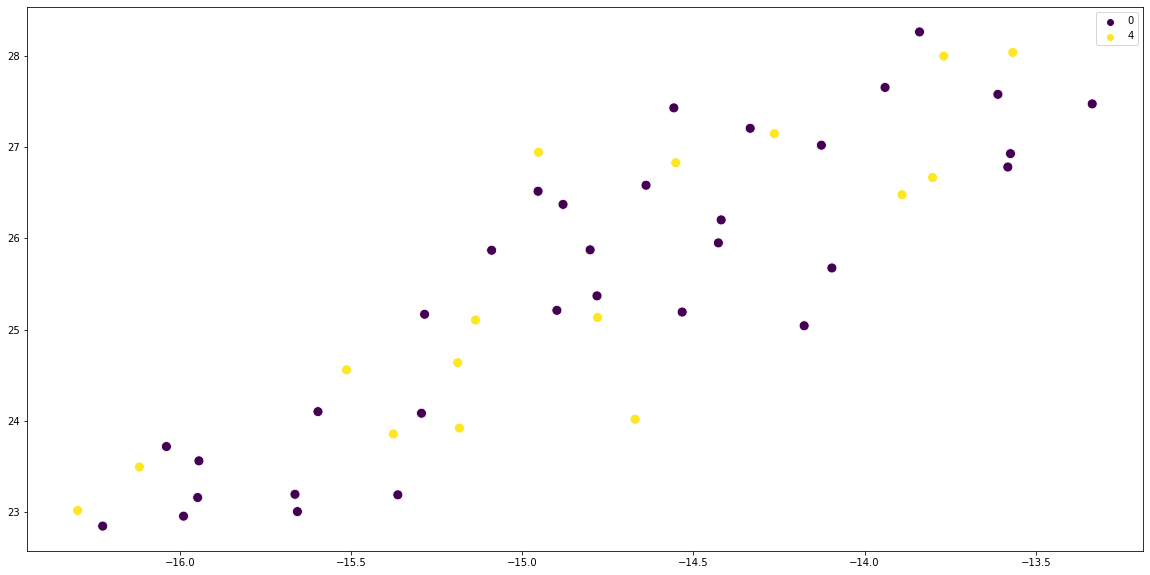

In [23]:
z = unsupervised_model.embedding.squeeze(0).detach().cpu()
# Now let's assign for every node of z the corresponding cluster using kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
#kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
# Let's plot the kmeans over the embedding
tsne = TSNE(n_components=2, random_state=1234)
tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
plt.figure(figsize=(20,10))
sns.scatterplot(x=tsne_obj[:48,0], y=tsne_obj[:48,1],s=100,hue=data.y[:48],palette='viridis')
plt.show()


In [ ]:
# Now let's plot all the khops
new_adj_rewired = unsupervised_model.new_adj_rewired.detach().cpu()
previous_adj = torch.zeros_like(new_adj_rewired)
adjs = []
for i in range(40):
    adj = torch.zeros_like(new_adj_rewired)
    top_min = torch.topk(new_adj_rewired, i, dim=1, largest=False, sorted=True)
    adj.scatter_(1, top_min.indices, 1)
    adj = adj - previous_adj
    # if there is any negative value, replace it with 0
    adj[adj < 0] = 0
    adjs.append(adj.numpy())
    previous_adj = adj

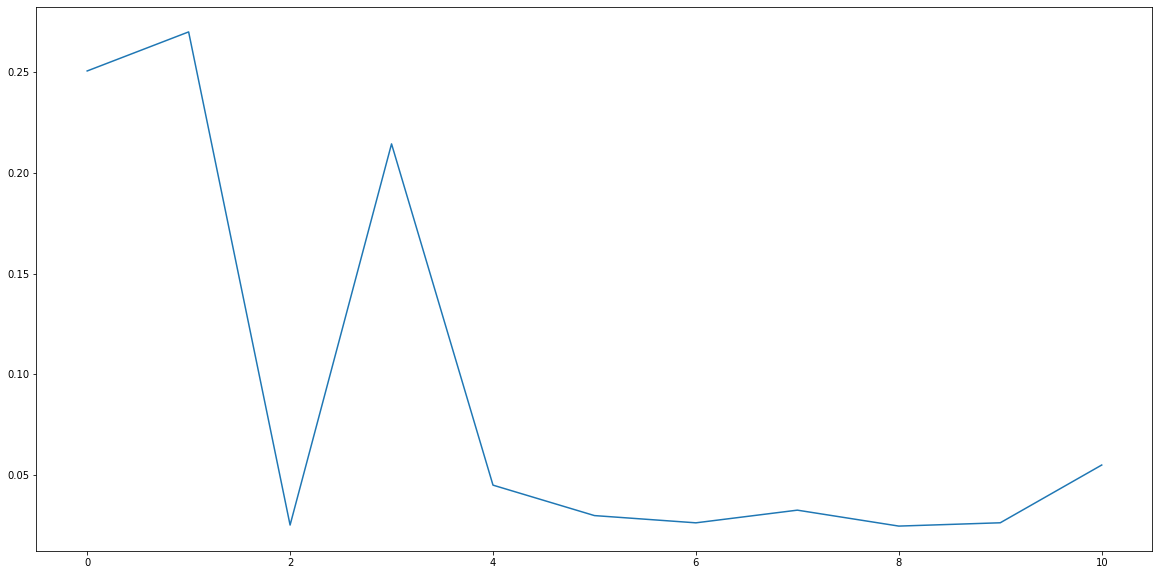

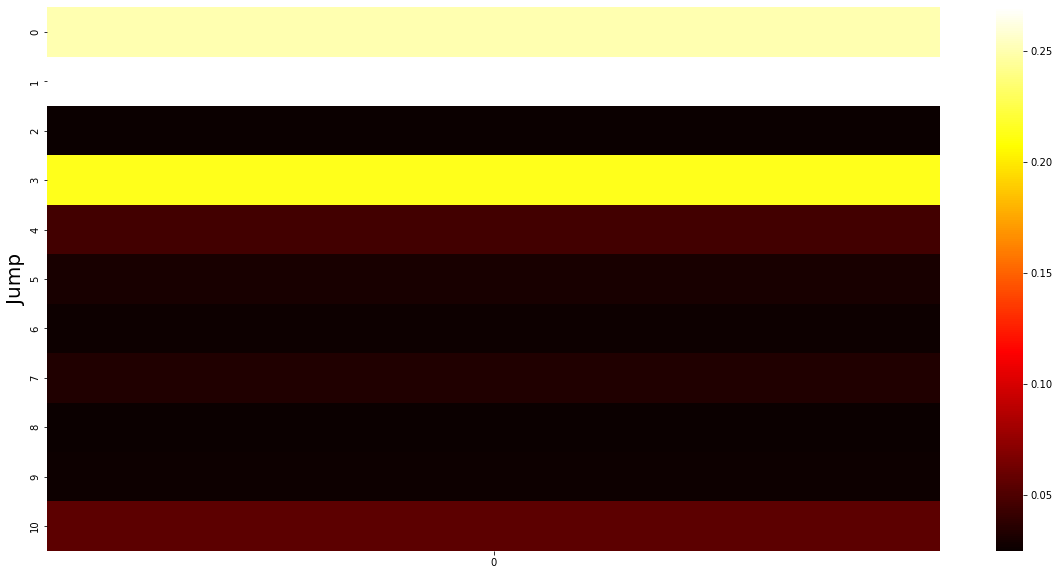

In [ ]:
alfas = torch.softmax(model.att, dim=0).unsqueeze(1).detach().cpu().numpy()
# Parse alfas to a 2D matrix
# Plot the alphas
plt.figure(figsize=(20,10))
plt.plot(alfas)
plt.show()
# Now plot as an image
plt.figure(figsize=(20,10))
sns.heatmap(alfas, cmap='hot')
plt.ylabel('Jump', fontsize=20)
plt.show()

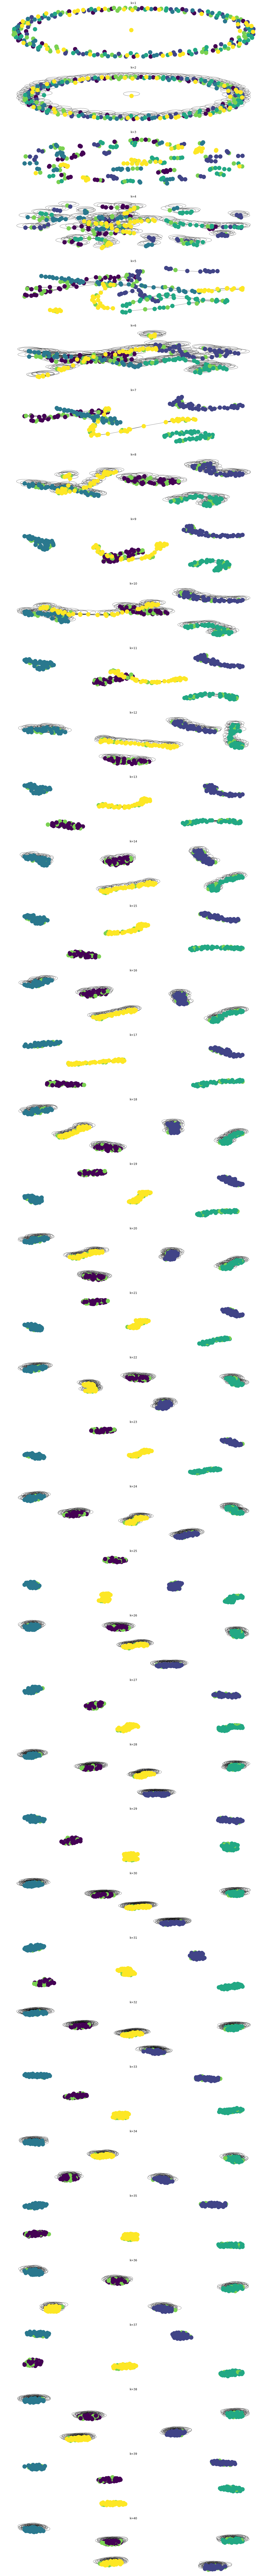

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

In [ ]:
# Now let's plot all the khops
fig, axs = plt.subplots(40,1,figsize=(20,200))
for f in range(40):
    # Parse the adj to a networkx graph
    G = nx.from_numpy_matrix(adjs[f])
    for i in range(len(sizes)):
        for j in range(sizes[i]):
            G.nodes[j+i*35]['color'] = i
    pos = nx.spring_layout(G,seed=1234)
    plt.figure(figsize=(15,7))
    #draw nodes with mapped color
    nx.draw(G,
            pos=pos,
            node_color= data.y.numpy(),
            edge_color='black',
            width=0.55,
            style='solid',
            linewidths=1,
            cmap=plt.cm.viridis,
            #node_size=100,
            with_labels=False,
            alpha=1,
            ax=axs[f])
    axs[f].set_title(f'k={f+1}')
plt.show()